In [1]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm
import matplotlib.patheffects # for adding borders around text

import textwrap
import seaborn
import squarify

#import ttf_opensans

In [2]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

In [3]:
footer_color = "#222222"
footer_lineheight = 1.2
footer_fontsize = 14

# default height of a figure is 450 pixels

# gemstyle does this:
# specify a base_ratio, then set base_size = base_ratio*16
# 1. add 6 line margin all the way around
# 2. color of title is "#222222", margin 6666, size=base_size*1.5, lineheight=1.35, bold font
# 3. color of subtitle is "#333333", margin 0666, padding top=12, bottom=12, size=base_size*1.15, lineheight=1.45
# 4. set caption info as linehight=1.2, size=base_size*0.875, color="#222222", margin=18,6,6,6

base_ratio = 1.0
base_size = base_ratio * 16
color_title = "#222222"
color_subtitle = "#333333"
color_grid = "#cbcbcb"

text_weight_normal = 400
text_weight_bold = 700

# save fig
#' @keywords save_gem_plot
#' @examples
#' save_gem_plot(
#' plot_grid = line_plot_with_gem_footer,
#' save_filepath = "filename_that_my_plot_should_be_saved_to-nc.png",
#' width_pixels = 770,
#' height_pixels = 540,
#' resolution = 4
#' )
#'
#' @export
# save plot function - now separated from finalise_plot function and setting the resolution as part of the arguments
# save_gem_plot <- function (plot_grid, save_filepath, width_pixels = 640, height_pixels = 450, resolution = 3) {
#   grid::grid.draw(plot_grid)

#   #save it
#   ggplot2::ggsave(plot=plot_grid,
#                   width= (width_pixels/72),
#                   height= (height_pixels/72),
#                   dpi = resolution * 100,
#                   filename = save_filepath,
#                   bg="white")
# }

#width_pixels = 640 # default
#height_pixels = 450 # default

## define colors used in bars

In [4]:
# sel_cmap = matplotlib.colormaps['Reds']
# tracker_operating = sel_cmap(0.999)
# tracker_construction = sel_cmap(0.8)
# tracker_proposed = sel_cmap(0.6)
# tracker_shelved = sel_cmap(0.4)
# tracker_cancelled = sel_cmap(0.2)

tracker_construction = '#761200'
tracker_proposed = '#bf532c'
tracker_shelved = '#e3710c'
#tracker_cancelled = '#357a5d'
#tracker_cancelled = '#4e8a71'
tracker_cancelled = '#9abcae'

# import data directly from google sheets

In [95]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1WaBMIdfRWqSqXUw7_cKXo3RipyhPdnNN8flqEYfMZIA') # dec 2023 data release

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

pipes_df_orig = pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [16]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

In [17]:
status_list = ['Proposed', 
               'Construction', 
               'Shelved', 
               'Cancelled', 
               'Operating', 
               'Idle', 
               'Mothballed', 
               'Retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

#country_list = sorted(list(set(terms_df_orig['Country'])))
#region_list = sorted(list(set(terms_df_orig['Region'])))

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [18]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

missing_wiki_projectids = pipes_df_orig.loc[pipes_df_orig.Wiki==''].ProjectID.tolist()
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

country_ratios_df.replace('--', numpy.nan, inplace=True)
country_ratios_df = country_ratios_df.loc[~country_ratios_df.ProjectID.isin(missing_wiki_projectids)]

# km by country, km by region calculations

In [19]:
dict_subregion_region = pandas.Series(region_df_orig.Region.values, index=region_df_orig.SubRegion).to_dict()
dict_subregion_region

{'Sub-Saharan Africa': 'Africa',
 'Northern Africa': 'Africa',
 'Latin America and the Caribbean': 'Americas',
 'Northern America': 'Americas',
 'Southern Asia': 'Asia',
 'Western Asia': 'Asia',
 'South-eastern Asia': 'Asia',
 'Eastern Asia': 'Asia',
 'Central Asia': 'Asia',
 'Northern Europe': 'Europe',
 'Southern Europe': 'Europe',
 'Western Europe': 'Europe',
 'Eastern Europe': 'Europe',
 'Polynesia': 'Oceania',
 'Australia and New Zealand': 'Oceania',
 'Melanesia': 'Oceania',
 'Micronesia': 'Oceania',
 '--': '--'}

In [20]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [21]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    km_by_country_df[status] = country_ratios_fuel_df_status.groupby('Country')['MergedKmByCountry'].sum()
    km_by_subregion_df[status] = country_ratios_fuel_df_status.groupby(['Region','SubRegion'])['MergedKmByCountry'].sum()
    km_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_subregion_df = km_by_subregion_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)
km_by_region_df = km_by_region_df.fillna(0)

#km_by_region_df.sort_index(level='Region', inplace=True)
#km_by_region_df = km_by_region_df.loc[~(km_by_region_df==0).all(axis=1)]

# total
# km_by_region_df.loc['Total',:] = km_by_region_df.sum(axis=0).values
# km_by_country_df.loc['Total',:] = km_by_country_df.sum(axis=0).values

km_by_subregion_df['Proposed+Construction'] = km_by_subregion_df[['Proposed','Construction']].sum(axis=1)
km_by_subregion_df = km_by_subregion_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]

km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)
km_by_country_df = km_by_country_df.loc[~(km_by_country_df==0).all(axis=1)]
km_by_country_df.loc[:,'Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].Region
km_by_country_df.loc[:,'Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].SubRegion
km_by_country_df = km_by_country_df[['Region','Subregion','Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df = km_by_country_df.loc[(km_by_country_df.Region!='--')&
                                        (km_by_country_df.Subregion!='--')]

km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]

km_by_subregion_df.index.set_names(['Region','Subregion'], inplace=True)
km_by_subregion_df.loc['Total',:] = km_by_subregion_df.sum(axis=0).values
km_by_subregion_df.replace(0,'', inplace=False)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


Proposed Construction  \
Region   Subregion                                                 
Africa   Northern Africa                     4072.7       187.93   
         Sub-Saharan Africa                 18561.8       1582.0   
Americas Latin America and the Caribbean   17090.97       2170.0   
         Northern America                   8571.63      2515.84   
Asia     Central Asia                       3867.22      1604.33   
         Eastern Asia                      37446.81     30365.16   
         South-eastern Asia                 8849.03       1087.3   
         Southern Asia                     12731.61     22425.64   
         Western Asia                       6015.84      2153.52   
Europe   Eastern Europe                    21303.58      3830.21   
         Northern Europe                    1111.49          1.2   
         Southern Europe                    8526.75      1656.29   
         Western Europe                       708.3         82.0   
Oceania  Australia and New Zealand          9856.64          4.3   
         Melanesia                            320.0                
         Micronesia                                                
         Polynesia                                                 
Total                                     159034.37     69665.72   

                                         Proposed+Construction   Shelved  \
Region   Subregion                                                         
Africa   Northern Africa                               4260.63    172.21   
         Sub-Saharan Africa                            20143.8   1319.72   
Americas Latin America and the Caribbean              19260.97   3097.05   
         Northern America                             11087.47   3456.39   
Asia     Central Asia                                  5471.55             
         Eastern Asia                                 67811.97   1784.07   
         South-eastern Asia                            9936.33   2712.41   
         Southern Asia                                35157.25    1752.0   
         Western Asia                                  8169.36   1845.76   
Europe   Eastern Europe                               25133.79   4553.92   
         Northern Europe                               1112.69    1000.0   
         Southern Europe                              10183.04    764.54   
         Western Europe                                  790.3     69.25   
Oceania  Australia and New Zealand                     9860.94   3726.22   
         Melanesia                                       320.0     400.0   
         Micronesia                                                        
         Polynesia                                                         
Total                                                228700.09  26653.54   

                                         Cancelled   Operating     Idle  \
Region   Subregion                                                        
Africa   Northern Africa                     589.0     24859.7            
         Sub-Saharan Africa                 228.96     7141.52            
Americas Latin America and the Caribbean   2344.66    59836.28    331.0   
         Northern America                 20654.81   401851.87     50.0   
Asia     Central Asia                      2590.59    29099.49            
         Eastern Asia                      2827.38   127567.05            
         South-eastern Asia                 1329.0    17665.11            
         Southern Asia                    10509.97     39861.3            
         Western Asia                      9827.63    36466.83            
Europe   Eastern Europe                    8475.95   141231.72  1651.65   
         Northern Europe                   1003.77    25588.17            
         Southern Europe                   4436.09    27759.83            
         Western Europe                     2138.2    28610.48     8.35   
Oceania  Australia and New Zealand  

In [22]:
km_by_country_df.to_excel('km-by-country-region-subregion.xlsx')
km_by_country_df

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,36090.21,30313.36,66403.57,731.11,1462.87,122333.77,0.00,0.0,114.40
Russia,Europe,Eastern Europe,18444.52,2901.93,21346.45,1246.65,4904.56,113072.59,414.27,1177.3,2000.58
India,Asia,Southern Asia,5573.68,15283.00,20856.68,1055.00,4671.05,19019.42,0.00,0.0,0.00
Australia,Oceania,Australia and New Zealand,9856.64,4.30,9860.94,3726.22,7214.68,29524.31,0.00,0.0,0.00
United States,Americas,Northern America,7237.22,1448.00,8685.22,3374.58,14090.54,340248.82,50.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Libya,Africa,Northern Africa,0.00,0.00,0.00,0.00,115.56,6243.07,0.00,0.0,0.00
Liechtenstein,Europe,Western Europe,0.00,0.00,0.00,0.00,1.90,1.29,0.00,0.0,0.00
Luxembourg,Europe,Western Europe,0.00,0.00,0.00,0.00,0.00,150.95,0.00,0.0,0.00
Macao,Asia,Eastern Asia,0.00,0.00,0.00,0.00,0.00,12.80,0.00,0.0,0.00


In [23]:
km_by_country_df.sort_values('Construction', ascending=False).to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')
#km_by_country_df

In [24]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,22634.50,1769.93,24404.43,1491.93,817.96,32001.22,0.0,1107.39,0.00
Americas,25662.60,4685.84,30348.44,6553.44,22999.47,461688.15,381.0,224.00,0.00
Asia,68910.51,57635.95,126546.46,8094.24,27084.57,250659.78,0.0,1373.59,229.68
Europe,31650.12,5569.70,37219.82,6387.71,16054.01,223190.20,1660.0,5225.10,3182.27
Oceania,10176.64,4.30,10180.94,4126.22,7515.50,32754.31,0.0,0.00,0.00


## figure for km by subregion (marimekko/mosaic type)

In [25]:
treemap_colors = {'Americas':'#c75a00',
                  'Asia':'#580000',
                  'Europe':'#902c00',
                  'Africa':'#f98c28',
                  'Oceania':'#ffd370'}

In [26]:
km_by_subregion_df

Proposed  Construction  \
Region   Subregion                                                  
Africa   Northern Africa                    4072.70        187.93   
         Sub-Saharan Africa                18561.80       1582.00   
Americas Latin America and the Caribbean   17090.97       2170.00   
         Northern America                   8571.63       2515.84   
Asia     Central Asia                       3867.22       1604.33   
         Eastern Asia                      37446.81      30365.16   
         South-eastern Asia                 8849.03       1087.30   
         Southern Asia                     12731.61      22425.64   
         Western Asia                       6015.84       2153.52   
Europe   Eastern Europe                    21303.58       3830.21   
         Northern Europe                    1111.49          1.20   
         Southern Europe                    8526.75       1656.29   
         Western Europe                      708.30         82.00   
Oceania  Australia and New Zealand          9856.64          4.30   
         Melanesia                           320.00          0.00   
         Micronesia                            0.00          0.00   
         Polynesia                             0.00          0.00   
Total                                     159034.37      69665.72   

                                          Proposed+Construction   Shelved  \
Region   Subregion                                                          
Africa   Northern Africa                                4260.63    172.21   
         Sub-Saharan Africa                            20143.80   1319.72   
Americas Latin America and the Caribbean               19260.97   3097.05   
         Northern America                              11087.47   3456.39   
Asia     Central Asia                                   5471.55      0.00   
         Eastern Asia                                  67811.97   1784.07   
         South-eastern Asia                             9936.33   2712.41   
         Southern Asia                                 35157.25   1752.00   
         Western Asia                                   8169.36   1845.76   
Europe   Eastern Europe                                25133.79   4553.92   
         Northern Europe                                1112.69   1000.00   
         Southern Europe                               10183.04    764.54   
         Western Europe                                  790.30     69.25   
Oceania  Australia and New Zealand                      9860.94   3726.22   
         Melanesia                                       320.00    400.00   
         Micronesia                                        0.00      0.00   
         Polynesia                                         0.00      0.00   
Total                                                 228700.09  26653.54   

                                          Cancelled   Operating     Idle  \
Region   Subregion                                                         
Africa   Northern Africa                     589.00    24859.70     0.00   
         Sub-Saharan Africa                  228.96     7141.52     0.00   
Americas Latin America and the Caribbean    2344.66    59836.28   331.00   
         Northern America                  20654.81   401851.87    50.00   
Asia     Central Asia                       2590.59    29099.49     0.00   
         Eastern Asia                       2827.38   127567.05     0.00   
         South-eastern Asia                 1329.00    17665.11     0.00   
         Southern Asia                     10509.97    39861.30     0.00   
         Western Asia                       9827.63    36466.83     0.00   
Europe   Eastern Europe                     8475.95   141231.72  1651.65   
         Northern Europe                    1003.77    25588.17     0.00   
         Southern Europe                    4436.09    27759.83     0.00   
         Western Europe                     2138.20    28

In [27]:
# build bar thicknesses, normalized by total and by regional subtotals
km_by_subregion_df_toplot = km_by_subregion_df.drop('Total')

regional_sum_df = km_by_subregion_df_toplot.groupby(level='Region').sum()
region_order = regional_sum_df.sort_values(by='Proposed+Construction', ascending=False).index.values
regional_sum_df = regional_sum_df.reindex(index=region_order)

# sort first by construction values, THEN reorder based on region_order
km_by_subregion_df_toplot = km_by_subregion_df_toplot.sort_values(
    ['Region','Construction'], ascending=False).reindex(
    level=0, index=region_order)

# before normalizing stuff, get km thickness
bar_thickness_km_df = km_by_subregion_df_toplot[['Proposed+Construction']]
regional_sum_df_normalized = regional_sum_df/regional_sum_df.sum(axis=0)

# normalize km_by_subregion so that each region adds up to 1.0
km_by_subregion_df_toplot_normalized = km_by_subregion_df_toplot/regional_sum_df
# then multiply by region_sum_df_normalized so ALL regions add up to a total of 1.0
# this will be what you need to plot for a normalized y-axis marimekko
km_by_subregion_df_toplot_normalized = (km_by_subregion_df_toplot_normalized*regional_sum_df_normalized).replace(numpy.nan,0)

bar_thickness_df = km_by_subregion_df_toplot_normalized[['Proposed+Construction']]
# we only care about what's under construction or proposed, so normalize the first two columns by Proposed+Construction
bar_fractional_width_df = km_by_subregion_df_toplot_normalized[['Proposed','Construction']].div(
    km_by_subregion_df_toplot_normalized[['Proposed','Construction']].sum(axis=1), axis=0).replace(numpy.nan,0) 

# # remove all-zero rows
bar_thickness_df = bar_thickness_df.loc[(bar_thickness_df!=0).any(axis=1)]
bar_thickness_km_df = bar_thickness_km_df.loc[(bar_thickness_km_df!=0).any(axis=1)]
bar_fractional_width_df = bar_fractional_width_df.loc[(bar_fractional_width_df!=0).any(axis=1)]
bar_percentage_width_df = bar_fractional_width_df*100.

# add a colors column to bar_thickness_df
bar_thickness_df['Colors'] = ''
bar_thickness_km_df['Colors'] = ''
for idx,row in bar_thickness_df.iterrows():
    bar_thickness_df.loc[idx,'Colors'] = treemap_colors[idx[0]]
    bar_thickness_km_df.loc[idx,'Colors'] = treemap_colors[idx[0]]

km_by_subregion_df_toplot['Colors'] = ''
for idx,row in km_by_subregion_df_toplot.iterrows():
    km_by_subregion_df_toplot.loc[idx,'Colors'] = treemap_colors[idx[0]]

In [28]:
km_by_region_df['Proposed+Construction'].sum()

228700.09

## figure 1 - marimekko

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-0.17216589861751153, -0.1323529411764706, 'Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines')

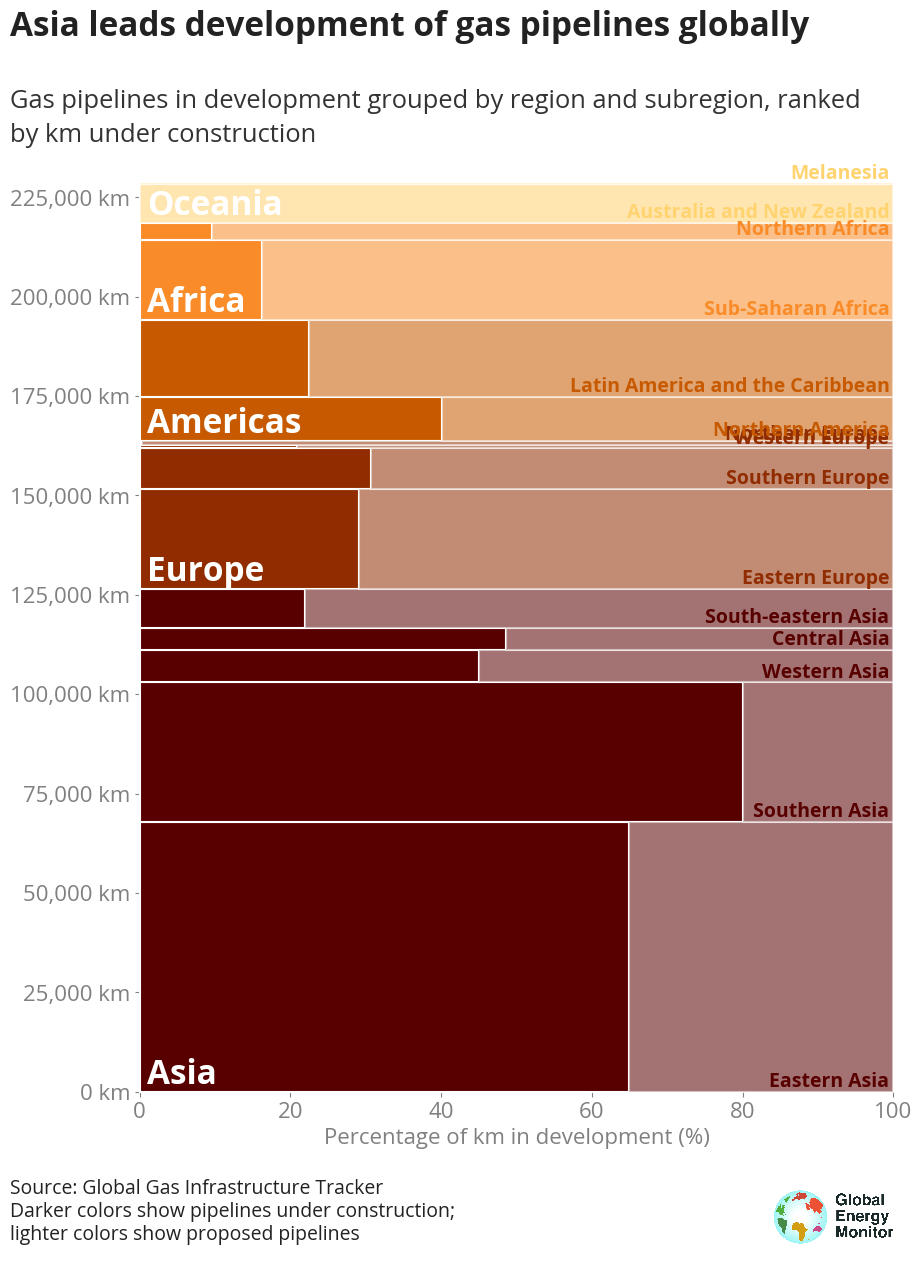

In [29]:
width_pixels = 700 # 640 default
height_pixels = 850 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

nbars = bar_thickness_df.shape[0]
bar_km_cumsum = bar_thickness_km_df['Proposed+Construction'].cumsum().values
bar_lower_edges = numpy.append(numpy.array(0), bar_km_cumsum[:-1])
bar_center_points = (numpy.append(numpy.array(0), bar_km_cumsum)[1:] - numpy.append(numpy.array(0), bar_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), bar_km_cumsum[:-1])

region_km_cumsum = regional_sum_df['Proposed+Construction'].cumsum().values
region_lower_edges = numpy.append(numpy.array(0), region_km_cumsum[:-1])
region_center_points = (numpy.append(numpy.array(0), region_km_cumsum)[1:] - numpy.append(numpy.array(0), region_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), region_km_cumsum[:-1])

ax = fig.add_subplot(111)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.Construction,
        height=bar_thickness_km_df['Proposed+Construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        left=0,
        clip_on=False)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.Proposed,
        height=bar_thickness_km_df['Proposed+Construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        alpha=0.55,
        left=bar_percentage_width_df.Construction,
        clip_on=False)

for i in range(nbars):
    ax.text(s=bar_thickness_km_df.index.get_level_values('Subregion').tolist()[i],
            x=99.5,
            y=bar_lower_edges[i]+0.01,
            ha='right',
            va='bottom',
            color=bar_thickness_km_df['Colors'].tolist()[i],
            size=base_size*0.875,
            weight=text_weight_bold)

for i in range(region_list.__len__()):
    ax.text(s=region_order[i],
            x=1,
            y=region_lower_edges[i]+0.005,#region_center_points[i],
            ha='left',
            va='bottom',
            size=base_size*1.5,
            color='1',
            weight=text_weight_bold)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(labelsize=base_size,
               color=axis_text_color,
               labelcolor=axis_text_color,)

# format axis to have proper units and commas in thousands place
ax.yaxis.set_ticks(numpy.arange(0,ax.get_ylim()[1],25000))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_ylim(0,bar_thickness_km_df.sum().values[0])
ax.set_xlim(0,100.)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2

ax.set_axisbelow(True)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Gas pipelines in development grouped by region and subregion, ranked\nby km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Asia leads development of gas pipelines globally',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.set_xlabel('Percentage of km in development (%)',
              size=base_size, color=axis_text_color)

# LEGEND AND GEM LOGO
ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.25*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

# ax.tick_params(labelsize=font_size)
# ax.set_ylabel('km of pipelines in development', size=font_size)
# ax.set_xlabel('Fraction of pipelines under construction (left)\nand proposed (right)', size=font_size)

# projects by country, by region

In [30]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_country_df[status] = country_ratios_fuel_df_status.groupby('ProjectID')['MergedKmByCountry'].count()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].count()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [31]:
num_by_region_df

,Proposed,Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,42,5,5,6,127,0.0,2.0,0.0
Americas,122,30,30,83,432,2.0,2.0,0.0
Asia,265,175,33,48,1051,0.0,2.0,4.0
Europe,204,35,24,62,974,4.0,15.0,7.0
Oceania,23,1,13,15,96,0.0,0.0,0.0


## percent pipelines with start date (sanity check)

In [32]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [33]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.4654471544715447

## regional pipelines started in given year

In [34]:
pipes_df_orig['StartYearEarliest'].min()

1904.0

In [35]:
years_array = numpy.arange(float(pipes_df_orig['StartYearEarliest'].min()), 
                           float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [36]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='oil']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

## figure 2 - top 15 countries proposed+construction

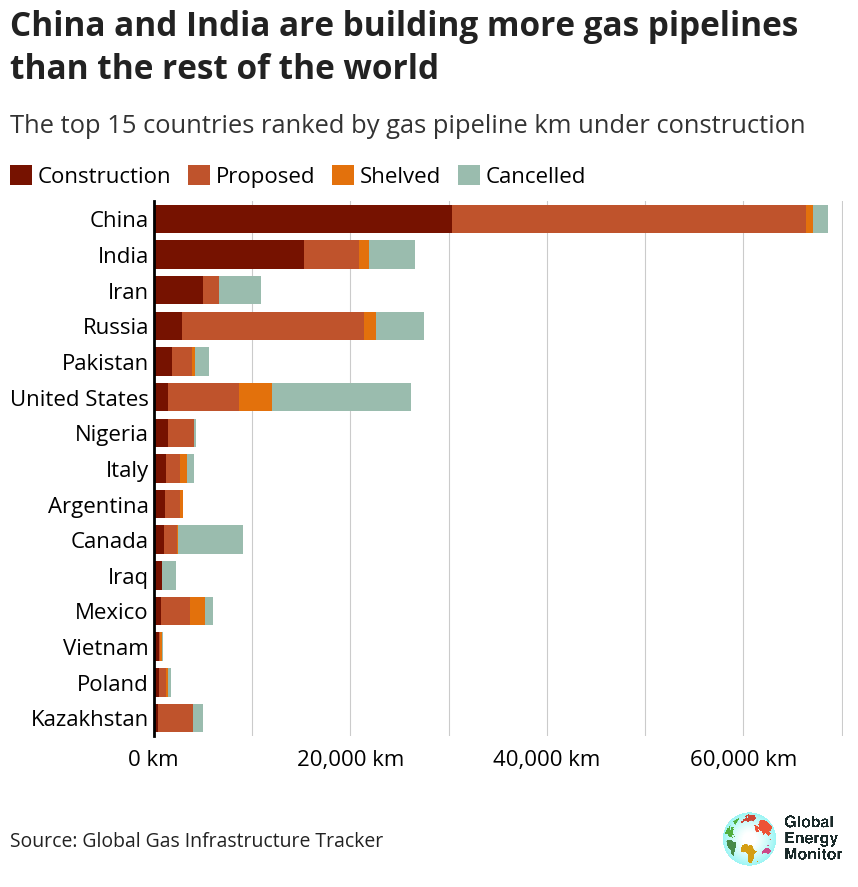

In [37]:
width_pixels = 640
height_pixels = 500
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
nbars=15

country_order = km_by_country_df.sort_values('Construction', ascending=False).index[:nbars][::-1]

ax = fig.add_subplot(111)

bar_height = 0.8

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,
        label='Proposed',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,
        label='Shelved',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,
        label='Cancelled',
        height=bar_height)

# FORMATTING
ax.tick_params(labelsize=base_size)
ax.tick_params(which='both',size=0)
ax.tick_params('x', pad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(2)

# format axis to have proper units and commas in thousands place
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_xlim(0,70100)
ax.set_ylim(-.5,nbars-.5)
ax.set_xticks([0,20000,40000,60000])

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2
ax.xaxis.grid(which='both',
              color=color_grid)

ax.set_axisbelow(True)
ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(country_order)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_locatio"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,_ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])
legend = ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

# now get tight bbox again for further placement AFTER legend is added
bbox = legend.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='The top 15 countries ranked by gas pipeline km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=y_location+0.05,
        ha='left',
        va='bottom',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='China and India are building more gas pipelines\nthan the rest of the world',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle+0.05,#1.2,
        ha='left',
        va='bottom',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.text(s='Source: Global Gas Infrastructure Tracker',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.22*450/height_pixels, # make sure the caption adjust appropriately relative to default height of 450
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.15), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# mp.savefig('../figures/Figure02-gas-pipelines_top-20-countries-sorted-by-construction.png',
#           bbox_inches='tight',
#           transparent=False,
#           dpi=300)

# mp.savefig('../figures/Figure02-gas-pipelines_top-20-countries-sorted-by-construction.pdf',
#           bbox_inches='tight', 
#           transparent=False)

In [38]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.183803462487798

# parent analysis

In [39]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['Proposed','Construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    if parent_string == '--':
        parent_string = 'Unknown [unknown %]'
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

## print out leading parent companies

In [40]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

parent_country_km_df_table['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [41]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (Proposed + Construction)'] = parent_country_km_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]

,Pipeline Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs,Number of Projects
"National Petroleum and Natural Gas Pipeline Network Group Co., Ltd.","China, North Korea",China,10165.0241,14868.6436,25033.667700,"P4495, P4513, P4526, P4556, P4557, P4558, P4561, P4579, P4605, P4622, P4644, P4659, P4660, P4661, P4662, P4663, P4664, P4665, P4666, P4687, P4689, P4690, P4698, P4700, P4701, P4702, P4703, P4704, P4705, P4707, P4708, P4709, P4711, P4716, P4722, P4723, P4747, P4748, P4749, P4750, P4751, P4752, P4753, P4784, P4785, P4786, P4787, P4790, P4791, P4836, P4840, P4842, P4843, P4844, P4852, P4854, P4855, P4880, P4881, P4884, P4896, P4902, P4903, P4910, P4914, P4916, P4917, P4921, P4922, P4923, P4931,...",89
Gazprom,"China, Mongolia, Russia, Bulgaria, Iran, Pakistan, Serbia",Russia,19056.3425,2765.416667,21821.759167,"P3894, P3895, P5409, P0734, P1336, P2287, P2313, P2327, P2346, P2425, P2437, P3369, P3370, P3604, P3607, P3725, P3971, P3972, P3973, P3974, P3977, P3978, P3979, P3980, P3981, P3982, P3990, P3991, P3992, P3996, P3997, P3998, P4012, P4013, P4056, P4063, P4076, P4077, P4078, P4080, P4081, P4083, P4085, P4092, P4093, P4094, P4095, P4096, P4109, P4110, P4111, P4130, P4131, P4132, P4142, P4143, P4144, P4149, P4150, P4156, P4166, P4167, P4171, P4172, P4210, P5402, P5403, P5404, P5510, P5521, P3174,...",79
GAIL (India) Limited,"Turkmenistan, Myanmar, India, Pakistan, Afghanistan, Bangladesh",India,7930.6995,7695.366667,15626.066167,"P0766, P0928, P0929, P0932, P0954, P1309, P2211, P2215, P2216, P2746, P2752, P3906, P3912",18
Iran Ministry of Petroleum,"Iran, Pakistan, Oman, Azerbaijan",Iran,400.0,6137.0,6537.000000,"P0441, P0448, P0452, P2225, P5984, P6006, P6009",10
Nigerian National Petroleum Corporation,"Joint regime area (Senegal/Guinea Bissau), Algeria, Morocco, Western Sahara, Spain, Nigeria, Niger, The Gambia, Ghana, Liberia, Senegal, Sierra Leone, Côte d'Ivoire, Mauritania, Guinea-Bissau, Guinea",Nigeria,4927.638333,1427.0,6354.638333,"P0463, P0460, P0488, P1313, P4185",20
Enagás,"China, Bulgaria, Greece, Albania, Italy, Spain",Spain,4501.946667,39.732,4541.678667,"P4950, P4964, P4965, P4967, P4977, P4978, P4987, P4988, P4989, P4990, P4991, P4402, P1705, P3137, P3203, P4361, P4362, P4363, P4403, P4405, P4406, P4425",25
Transgaz,"Romania, Morocco, Serbia, Mozambique, South Africa, Namibia",Romania,4029.67,,4029.670000,"P1702, P1706, P1714, P2727, P2248, P2250, P2254",9
Transnet,South Africa,South Africa,3660.02,,3660.020000,"P2469, P2470, P2471, P2472, P2473, P2474, P3337, P3338, P3339",9
"Anhui Province Natural Gas Development Co., Ltd.",China,China,574.75,2524.0,3098.750000,"P4580, P4582, P4583, P4584, P4585, P4586, P4589, P4590, P4591, P4592, P4593, P4594, P4596, P4598, P4600, P4603",16
TC Energy,"Mexico, Canada, United States",Canada,1644.5,1292.34,2936.840000,"P0434, P1268, P3921, P0167, P0243, P2005, P2530, P2556, P3186, P3187, P3188, P3189, P3279, P3609, P3611, P3613, P4446, P4447, P5416, P5547",20


### count fraction of available capacity information

count

In [42]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Africa        7
Americas    125
Asia        327
Europe      106
Oceania      17
Name: CapacityBOEd, dtype: int64

fraction

In [43]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
Americas,0.845
Asia,0.661
Oceania,0.654
Europe,0.522
Africa,0.280


In [44]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()

In [45]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()).median()

In [46]:
pipes_df_orig['CapacityBcm/y'].mean()

562.6159382793016

In [47]:
pipes_df_orig['CapacityBcm/y'].std()

11533.86418119282

In [48]:
print(median_capacity)
print(abs_dist_from_med_capacity)

3.5
3.02


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

## pick out high and low quantiles

In [49]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Gas')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

144334.95287
16687209.058


In [50]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

In [51]:
country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                    (country_ratios_df['LengthKnownKmByCountry'].notna())].shape

(1034, 36)

In [52]:
country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas')].shape

(4012, 36)

In [53]:
1034/4012

0.2577268195413759

### global mean value

In [54]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2450601.7259236453

### calculate regional costs

In [55]:
region_list

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [56]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_7859/3912453063.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3096054.8000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()


In [57]:
pipes_costs_subregion_df = pandas.DataFrame(0, index=subregion_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for subregion in subregion_list:
    country_ratios_subregion_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['SubRegion']==subregion,:]
    pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()
    pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()

# for subregions with no data, inherit from the REGIONAL cost
for idx,row in pipes_costs_subregion_df.loc[pipes_costs_subregion_df.CostUSDPerKm.isnull()].iterrows():
    #print(pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'])
    which_region = idx
    pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'] = pipes_costs_region_df.loc[dict_subregion_region[which_region],'CostUSDPerKm']

pipes_costs_subregion_df.sort_values('CostUSDPerKm', ascending=False)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_7859/3870605072.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2847723.311764706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()


,CostUSDPerKm,DataPoints
Northern Europe,"5,757,914.647",10
Western Europe,"4,763,444.893",13
Northern America,"4,649,434.929",179
Sub-Saharan Africa,"3,928,708.954",5
Western Asia,"3,601,253.594",41
Latin America and the Caribbean,"2,958,363.579",43
Melanesia,"2,847,723.312",0
Micronesia,"2,847,723.312",0
Polynesia,"2,847,723.312",0
Australia and New Zealand,"2,847,723.312",17


In [58]:
pipes_costs_region_df

,CostUSDPerKm,DataPoints
Africa,"3,096,054.800",29
Americas,"4,308,253.867",217
Asia,"1,775,373.377",456
Europe,"2,995,574.749",134
Oceania,"2,847,723.312",17


In [59]:
country_ratios_region_df['CostUSDPerKm'].mean()

2847723.311764706

In [60]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Americas,4.308,217
Africa,3.096,29
Europe,2.996,134
Oceania,2.848,17
Asia,1.775,456


In [61]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_subregion_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Northern Europe,5.758,10
Western Europe,4.763,13
Northern America,4.649,179
Sub-Saharan Africa,3.929,5
Western Asia,3.601,41
Latin America and the Caribbean,2.958,43
Melanesia,2.848,0
Micronesia,2.848,0
Polynesia,2.848,0
Australia and New Zealand,2.848,17


# tables etc.

## table for stranded asset calculations

## country-level capex estimates

In [62]:
pipes_costs_region_df.sort_values('CostUSDPerKm', ascending=False)

,CostUSDPerKm,DataPoints
Americas,"4,308,253.867",217
Africa,"3,096,054.800",29
Europe,"2,995,574.749",134
Oceania,"2,847,723.312",17
Asia,"1,775,373.377",456


add a cost USD estimate column and estimate costs based on region and km by country

In [63]:
pipes_costs_subregion_df

,CostUSDPerKm,DataPoints
Australia and New Zealand,"2,847,723.312",17
Central Asia,"2,283,624.052",21
Eastern Asia,"1,430,084.314",374
Eastern Europe,"2,847,218.449",74
Latin America and the Caribbean,"2,958,363.579",43
Melanesia,"2,847,723.312",0
Micronesia,"2,847,723.312",0
Northern Africa,"2,653,707.281",26
Northern America,"4,649,434.929",179
Northern Europe,"5,757,914.647",10


In [64]:
country_ratios_df.reset_index(drop=True, inplace=True)
country_ratios_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_df.iterrows():
    # calculate cost
    cntry = row.Country
    #region = row.Region
    subregion = row.SubRegion
    km_by_cntry = row.LengthKnownKmByCountry
    #country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry
    country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_subregion_df.loc[subregion, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

In [65]:
country_ratios_df.SubRegion.unique()

array(['Sub-Saharan Africa', 'Latin America and the Caribbean',
       'Southern Europe', 'Australia and New Zealand', 'Central Asia',
       'Eastern Asia', 'Eastern Europe', 'Melanesia', 'Northern Africa',
       'Northern America', 'Northern Europe', 'South-eastern Asia',
       'Southern Asia', 'Western Asia', 'Western Europe'], dtype=object)

In [90]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion_country)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)
capex_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_df_status = country_ratios_df.loc[country_ratios_df.Status==status]
    country_ratios_df_status = country_ratios_df_status.loc[~country_ratios_df_status.SubRegion.isnull()]
    capex_by_country_df[status] = country_ratios_df_status.groupby(['Region','SubRegion','Country'])['CostUSDEstimate'].sum()/1e9
    capex_by_region_df[status] = country_ratios_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9
    capex_by_subregion_df[status] = country_ratios_df_status.groupby(['Region','SubRegion'])['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)
capex_by_subregion_df = capex_by_subregion_df.fillna(0)

capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.loc['Total',:] = capex_by_region_df.sum(axis=0).values

capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#capex_by_country_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_country_df.loc['Total',:] = capex_by_country_df.sum(axis=0).values
capex_by_country_df = capex_by_country_df.loc[~(capex_by_country_df==0).all(axis=1)]
capex_by_country_df = capex_by_country_df.replace(0,'')

capex_by_subregion_df['Proposed+Construction'] = capex_by_subregion_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_subregion_df = capex_by_subregion_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#capex_by_subregion_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_subregion_df.loc['Total',:] = capex_by_subregion_df.sum(axis=0).values

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [91]:
capex_by_country_df

Proposed Construction  \
Region  SubRegion                 Country                                  
Africa  Northern Africa           Algeria             4.077                
                                  Egypt               0.894        0.213   
                                  Libya               0.193        0.265   
                                  Morocco             5.523                
                                  Sudan                                    
...                                                     ...          ...   
Europe  Western Europe            Switzerland         0.071                
Oceania Australia and New Zealand Australia          23.072        0.049   
                                  New Zealand                              
        Melanesia                 Papua New Guinea    0.911                
Total                                               529.078      193.905   

                                                   Proposed+Construction  \
Region  SubRegion                 Country                                  
Africa  Northern Africa           Algeria                          4.077   
                                  Egypt                            1.107   
                                  Libya                            0.458   
                                  Morocco                          5.523   
                                  Sudan                                    
...                                                                  ...   
Europe  Western Europe            Switzerland                      0.071   
Oceania Australia and New Zealand Australia                       23.120   
                                  New Zealand                              
        Melanesia                 Papua New Guinea                 0.911   
Total                                                            722.983   

                                                   Shelved Cancelled  \
Region  SubRegion                 Country                              
Africa  Northern Africa           Algeria            0.464     0.833   
                                  Egypt                        1.236   
                                  Libya                        0.523   
                                  Morocco                              
                                  Sudan                                
...                                                    ...       ...   
Europe  Western Europe            Switzerland                  0.340   
Oceania Australia and New Zealand Australia          3.135    17.132   
                                  New Zealand                          
        Melanesia                 Papua New Guinea   1.139     0.857   
Total                                              115.227   445.974   

                                                   Operating   Idle  \
Region  SubRegion                 Country                             
Africa  Northern Africa           Algeria             42.218          
                                  Egypt               19.269          
                                  Libya               35.464          
                                  Morocco                             
                                  Sudan                3.912          
...                                                      ...    ...   
Europe  Western Europe            Switzerland          2.046          
Oceania Australia and New Zealand Australia           83.170          
                                  New Zealand          7.783          
        Melanesia                 Papua New Guinea     2.794          
Total                                              4,508.234 13.810   

                                                   Mothballed Retired  
Region  SubRegion                 Country                              
Africa  Northern Africa           Algeria               1.458       

In [92]:
capex_by_region_df.replace(0,'')

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,86.891,11.477,98.368,0.777,11.203,155.255,,2.939,
Americas,123.380,52.194,175.575,71.874,269.532,"2,665.323",1.212,0.883,30.007
Asia,175.454,117.193,292.647,22.997,79.496,670.711,3.081,11.535,15.330
Europe,119.369,12.992,132.362,15.304,67.755,923.199,9.518,40.191,14.695
Oceania,23.983,0.049,24.032,4.275,17.988,93.747,,,0.533
Total,529.078,193.905,722.983,115.227,445.974,"4,508.234",13.810,55.547,60.564


In [93]:
capex_by_subregion_df.index = capex_by_subregion_df.index.set_names(['Region','Subregion'])
capex_by_subregion_df.replace(0,'')

Proposed Construction  \
Region   Subregion                                               
Africa   Northern Africa                   14.177        0.479   
         Sub-Saharan Africa                72.714       10.998   
Americas Latin America and the Caribbean   62.890        6.267   
         Northern America                  60.490       45.927   
Asia     Central Asia                       5.657        7.593   
         Eastern Asia                      53.399       48.326   
         South-eastern Asia                17.083        3.868   
         Southern Asia                     39.212       49.649   
         Western Asia                      60.103        7.756   
Europe   Eastern Europe                    64.796        9.777   
         Northern Europe                   13.361        0.007   
         Southern Europe                   25.117        2.818   
         Western Europe                    16.096        0.391   
Oceania  Australia and New Zealand         23.072        0.049   
         Melanesia                          0.911                
         Micronesia                                              
         Polynesia                                               
Total                                     529.078      193.905   

                                         Proposed+Construction Shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                14.656   0.600   
         Sub-Saharan Africa                             83.712   0.177   
Americas Latin America and the Caribbean                69.158   7.711   
         Northern America                              106.417  64.163   
Asia     Central Asia                                   13.250   0.217   
         Eastern Asia                                  101.725   2.551   
         South-eastern Asia                             20.951   6.945   
         Southern Asia                                  88.861   4.249   
         Western Asia                                   67.859   9.035   
Europe   Eastern Europe                                 74.573   8.652   
         Northern Europe                                13.368   0.400   
         Southern Europe                                27.935   2.714   
         Western Europe                                 16.486   3.539   
Oceania  Australia and New Zealand                      23.120   3.135   
         Melanesia                                       0.911   1.139   
         Micronesia                                                      
         Polynesia                                                       
Total                                                  722.983 115.227   

                                         Cancelled Operating   Idle  \
Region   Subregion                                                    
Africa   Northern Africa                     2.749   105.202          
         Sub-Saharan Africa                  8.455    50.053          
Americas Latin America and the Caribbean    15.051   252.612  0.979   
         Northern America                  254.481 2,412.711  0.232   
Asia     Central Asia                        2.219    75.219          
         Eastern Asia                       15.624   241.899  0.066   
         South-eastern Asia                  3.624    42.713          
         Southern Asia                      28.902   120.748          
         Western Asia                       29.128   190.133  3.014   
Europe   Eastern Europe                     34.357   588.293  7.778   
         Northern Europe                     5.780   158.850  1.411   
         Southern Europe                    15.965    62.461  0.290   
         Western Europe                     11.654   113.595  0.040   
Oceania  Australia and New Zealand          17.132    90.953          
         Melanesia                           0.857     2.794          
         Micronesia             

In [94]:
capex_by_country_df.to_excel('capex-by-country.xlsx')
capex_by_country_df.tail()

Proposed Construction  \
Region  SubRegion                 Country                                  
Europe  Western Europe            Switzerland         0.071                
Oceania Australia and New Zealand Australia          23.072        0.049   
                                  New Zealand                              
        Melanesia                 Papua New Guinea    0.911                
Total                                               529.078      193.905   

                                                   Proposed+Construction  \
Region  SubRegion                 Country                                  
Europe  Western Europe            Switzerland                      0.071   
Oceania Australia and New Zealand Australia                       23.120   
                                  New Zealand                              
        Melanesia                 Papua New Guinea                 0.911   
Total                                                            722.983   

                                                   Shelved Cancelled  \
Region  SubRegion                 Country                              
Europe  Western Europe            Switzerland                  0.340   
Oceania Australia and New Zealand Australia          3.135    17.132   
                                  New Zealand                          
        Melanesia                 Papua New Guinea   1.139     0.857   
Total                                              115.227   445.974   

                                                   Operating   Idle  \
Region  SubRegion                 Country                             
Europe  Western Europe            Switzerland          2.046          
Oceania Australia and New Zealand Australia           83.170          
                                  New Zealand          7.783          
        Melanesia                 Papua New Guinea     2.794          
Total                                              4,508.234 13.810   

                                                   Mothballed Retired  
Region  SubRegion                 Country                              
Europe  Western Europe            Switzerland                          
Oceania Australia and New Zealand Australia                     0.533  
                                  New Zealand                          
        Melanesia                 Papua New Guinea                     
Total                                                  55.547  60.564

## capex data - 15 leading countries by construction

In [70]:
country_order

Index(['Kazakhstan', 'Poland', 'Vietnam', 'Mexico', 'Iraq', 'Canada',
       'Argentina', 'Italy', 'Nigeria', 'United States', 'Pakistan', 'Russia',
       'Iran', 'India', 'China'],
      dtype='object')

In [71]:
km_by_country_df

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,"36,090.210","30,313.360","66,403.570",731.110,"1,462.870","122,333.770",0.000,0.000,114.400
Russia,Europe,Eastern Europe,"18,444.520","2,901.930","21,346.450","1,246.650","4,904.560","113,072.590",414.270,"1,177.300","2,000.580"
India,Asia,Southern Asia,"5,573.680","15,283.000","20,856.680","1,055.000","4,671.050","19,019.420",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.310",0.000,0.000,0.000
United States,Americas,Northern America,"7,237.220","1,448.000","8,685.220","3,374.580","14,090.540","340,248.820",50.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
Libya,Africa,Northern Africa,0.000,0.000,0.000,0.000,115.560,"6,243.070",0.000,0.000,0.000
Liechtenstein,Europe,Western Europe,0.000,0.000,0.000,0.000,1.900,1.290,0.000,0.000,0.000
Luxembourg,Europe,Western Europe,0.000,0.000,0.000,0.000,0.000,150.950,0.000,0.000,0.000
Macao,Asia,Eastern Asia,0.000,0.000,0.000,0.000,0.000,12.800,0.000,0.000,0.000


In [72]:
nbars = 15
country_order = km_by_country_df.sort_values('Construction', ascending=False).index.tolist()[:nbars]
capex_by_country_df.loc[country_order]

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,51.538,48.119,99.657,1.046,9.529,233.112,0.066,0.000,8.107
India,13.548,26.217,39.765,2.670,10.454,59.449,0.000,0.000,0.000
Iran,9.894,17.828,27.722,0.000,12.368,36.293,0.000,0.000,0.000
Russia,49.261,8.233,57.494,3.549,16.055,519.491,1.180,7.457,9.688
Pakistan,6.241,3.663,9.904,0.702,4.883,18.894,0.000,0.000,0.000
United States,51.614,11.457,63.071,28.666,170.009,"2,013.897",0.232,0.000,24.120
Nigeria,9.339,3.840,13.179,0.000,0.000,21.901,0.000,0.000,0.000
Italy,4.081,2.307,6.389,2.425,2.070,29.754,0.000,0.000,0.000
Argentina,10.929,4.124,15.053,1.109,0.000,63.395,0.000,0.109,0.000
Canada,8.876,34.470,43.346,35.498,84.472,398.814,0.000,0.000,5.887


## print out country-level stranded assets for report discussion

## in-dev for each country in list

# us infrastructure km and cost for Gulf Coast export buildout specifically

In [73]:
which_projectids = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                    (pipes_df_orig.Status.isin(['Proposed','Construction','Shelved']))&
                                    (pipes_df_orig.Countries=='United States')&
                                    (pipes_df_orig.AssociatedWithLNGExports=='yes')].ProjectID.tolist()

In [74]:
country_ratios_df.loc[(country_ratios_df.ProjectID.isin(which_projectids))].MergedKmByPipeline.sum()

4636.679999999999

In [75]:
country_ratios_df.loc[(country_ratios_df.ProjectID.isin(which_projectids))].CostUSDEstimate.sum()/1e9

27.79345628314301

# numbers for report

## amount already being constructed

In [76]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.3046160585245069

## capacity/potential emissions in development globally

In [77]:
pipes_df_subset.CapacityBOEd

5      16,846.670
24     14,440.000
30      7,220.000
34     27,436.010
35      1,097.440
          ...    
3746          NaN
3747    1,954.610
3748      229.900
3761      146.600
3772      239.670
Name: CapacityBOEd, Length: 901, dtype: object

In [78]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

9.66068329 million bpd


NameError: name 'co2_rate' is not defined

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

## total number of pipelines in dev

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

## top 10 pipelines

## biggest pipelines that went into construction in 2022/2023

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Construction','Operating']))&
                                                                  (pipes_df_orig.ConstructionYear.isin([2022,2023]))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

## biggest pipeline projects by name in China, rather than individual ProjectID

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['Construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].shape

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['Construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].LengthMergedKm.mean()

## km of pipeline with 2023, 2024 start years

In [ ]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2023],
      pipes_indev_startyear.loc['Construction',2024])

print(pipes_indev_startyear.loc['Proposed',2023],
      pipes_indev_startyear.loc['Proposed',2024])

## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [ ]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

In [ ]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [ ]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

## num in dev globally, whether capacity expansions or not

In [ ]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

In [ ]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

# delay/difficulty to build analysis

### delays in 2023

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status'])['LengthMergedKm'].sum()

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status','StartRegion'])['LengthMergedKm'].sum()

### timeline of pipeline completion

In [ ]:
# timeline of pipeline completion?
# need both proposal year and needs to be operational and have a start year
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
pipes_df_gas_with_completion_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')&
    (pipes_df_orig.ProposalYear!=pipes_df_orig.StartYearEarliest)]

In [ ]:
pipes_df_gas_with_completion_data.shape

In [ ]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear).mean()

In [ ]:
# mean rate of construction (km of pipeline per year)
numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)).mean()

In [ ]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)

In [ ]:
mp.hist(x=numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)),
       bins=50)

### how long are shelved pipelines hanging around?

In [ ]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Shelved')&
    #(pipes_df_orig.ShelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
numpy.array(2023-pipes_df_gas_with_shelved_data.ProposalYear).mean()

In [ ]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Shelved')&
    (pipes_df_orig.ShelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
# about 22 projects right now that are marked shelved AND have a proposal year
pipes_df_gas_with_shelved_data.ShelvedYear-pipes_df_gas_with_shelved_data.ProposalYear

In [ ]:
# about 22 projects right now that are marked shelved AND have a proposal year
numpy.array(pipes_df_gas_with_shelved_data.ShelvedYear-pipes_df_gas_with_shelved_data.ProposalYear).mean()

# China, India vs rest of world

In [ ]:
km_by_country_df.loc[['China','India']].Construction.sum()/km_by_country_df.Construction.sum()

In [ ]:
km_by_country_df.loc[['China','India']]['Proposed+Construction'].sum()/km_by_country_df['Proposed+Construction'].sum()

In [ ]:
km_by_country_df.loc[['China','India']].Construction.sum()

In [ ]:
km_by_country_df.Construction.sum()

In [ ]:
km_by_country_df.Construction.sum()-30313-15283

In [ ]:
km_by_country_df.loc['China'].Construction

In [401]:
km_by_country_df.loc['India'].Construction

15283.0

In [394]:
km_by_country_df.loc[['China','India']].Construction.sum()

45596.36

In [395]:
km_by_country_df.drop(['China','India']).Construction.sum()#loc[[~'China','India']]

24069.36

In [385]:
km_by_country_df.head()

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,"36,090.210","30,313.360","66,403.570",731.110,"1,462.870","122,333.770",0.000,0.000,114.400
Russia,Europe,Eastern Europe,"18,444.520","2,901.930","21,346.450","1,246.650","4,904.560","113,072.590",414.270,"1,177.300","2,000.580"
India,Asia,Southern Asia,"5,573.680","15,283.000","20,856.680","1,055.000","4,671.050","19,019.420",0.000,0.000,0.000
Australia,Oceania,Australia and New Zealand,"9,856.640",4.300,"9,860.940","3,726.220","7,214.680","29,524.310",0.000,0.000,0.000
United States,Americas,Northern America,"7,237.220","1,448.000","8,685.220","3,374.580","14,090.540","340,248.820",50.000,0.000,0.000
